# Differential spectra balance - Info preparation for the Second paper

In [58]:
# Main imports
import pandas as pd
import numpy as np
from matplotlib.pyplot import subplots
from typing import Callable

from modules.extra import dsb_fit
from modules.utils import growth
from modules.models import apply_noise

## Data models used

C:\Users\ringa\AppData\Local\Temp\ipykernel_59388\4054343446.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\ringa\AppData\Local\Temp\ipykernel_59388\4054343446.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


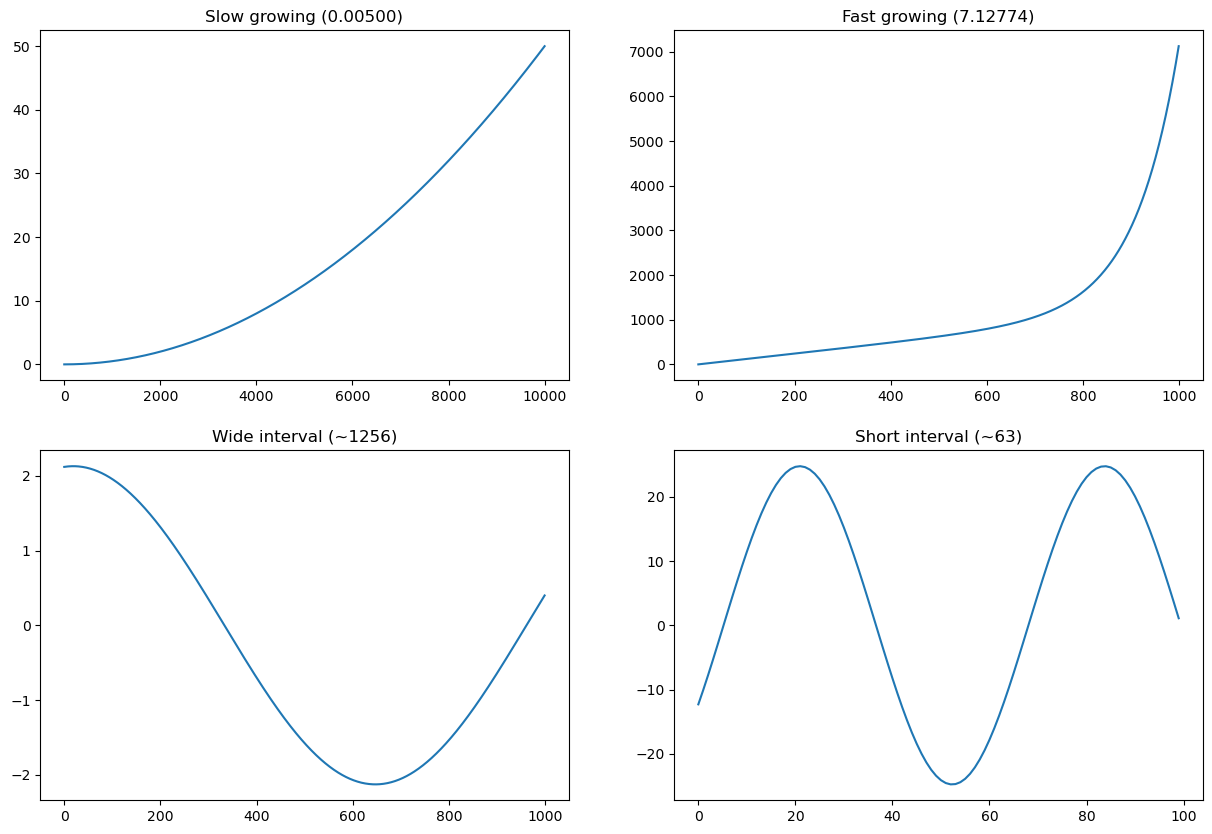

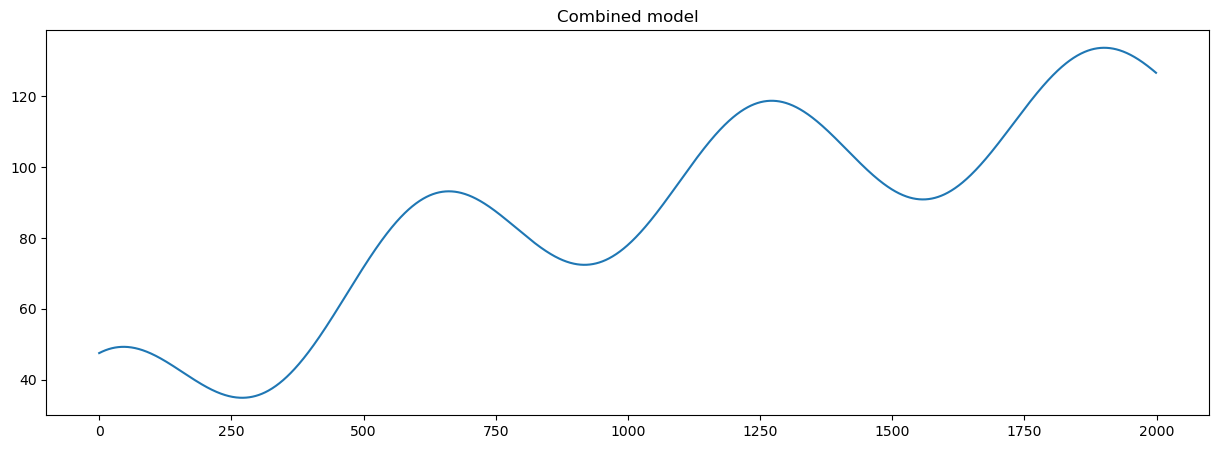

In [59]:
from modules.models import exponential1, exponential2
from modules.models import transcendental1, transcendental2
from modules.models import combined1

x1 = np.arange(10000)
y1 = exponential1(10000)
x2 = np.arange(1000)
y2 = exponential2(1000)
x3 = np.arange(1000)
y3 = transcendental1(1000)
x4 = np.arange(100)
y4 = transcendental2(100)

fig, ax = subplots(2, 2)
fig.set_figwidth(15)
fig.set_figheight(10)
ax[0, 0].plot(x1, y1)
ax[0, 0].set_title(f"Slow growing ({growth(y1):.5f})")
ax[0, 1].plot(x2, y2)
ax[0, 1].set_title(f"Fast growing ({growth(y2):.5f})")
ax[1, 0].plot(x3, y3)
ax[1, 0].set_title("Wide interval (~1256)")
ax[1, 1].plot(x4, y4)
ax[1, 1].set_title("Short interval (~63)")
fig.show()

fig, ax = subplots()
x5 = np.arange(2000)
y5 = combined1(2000)
fig.set_figwidth(15)
fig.set_figheight(5)
ax.plot(x5, y5)
ax.set_title("Combined model")
fig.show()

In [60]:
from modules.utils import rse, r_sq


# Main defines
def perform_test(
    func: str,
    main_var: str,
    data_model: Callable,
    size: int,
    noise_coeff: np.float64 = 10.0,
    test_ratio: np.float64 = 1.0,
    growth_coeff: np.float64 = 0.0
) -> list[np.ndarray]:
    test_size = int(np.ceil(size * test_ratio))

    if growth_coeff == 0:
        data = data_model(size + test_size)
    else:
        data = data_model(size + test_size, growth_coeff)
    data_n = apply_noise(data.copy(), sigma=(np.max(data) - np.min(data)) / noise_coeff)

    model = dsb_fit(func, main_var, data_n[:size], as_lambda=True)
    res = (
        data[:size],
        np.arange(size, dtype=np.float64),
        data[size:],
        np.arange(size, size + test_size, dtype=np.float64),
    )
    for i in [1, 3]:
        with np.nditer(res[i], op_flags=["readwrite"]) as it:
            for value in it:
                value[...] = model(value)

    return res


def display_stats(x, res, period=0, only_train=False):
    train_stats = [[], [], []]
    test_stats = [[], [], []]
    for r in res:
        if r == 0:
            train_stats[0].append(None)
            train_stats[1].append(None)
            if not only_train:
                test_stats[0].append(None)
                test_stats[1].append(None)
        else:
            train_stats[0].append(rse(r[0], r[1]))
            train_stats[1].append(r_sq(r[0], r[1]))
            if not only_train:
                test_stats[0].append(rse(r[2], r[3]))
                test_stats[1].append(r_sq(r[2], r[3]))

    fig, ax = subplots(1, 2)
    fig.set_figwidth(15)
    fig.set_figheight(5)
    ax[0].plot(x, train_stats[0], label="train", marker="o")
    if not only_train:
        ax[0].plot(x, test_stats[0], label="test", marker="o")
    ax[0].set_title("RSE")
    ax[0].legend(loc="lower right")
    ax[1].plot(x, train_stats[1], label="train", marker="o")
    if not only_train:
        ax[1].plot(x, test_stats[1], label="test", marker="o")
    ax[1].set_title("R_sq")
    ax[1].legend(loc="lower right")
    if period > 0:
        ax[0].axvline(x=period / 2)
        ax[0].axvline(x=period)
        ax[0].axvline(x=period * 1.5)
        ax[0].axvline(x=period * 2)
        ax[1].axvline(x=period / 2)
        ax[1].axvline(x=period)
        ax[1].axvline(x=period * 1.5)
        ax[1].axvline(x=period * 2)
    fig.show()


def print_stats(x, res, only_train=False):
    keys = ("train rse", "train r_sq")
    if not only_train:
        keys = ("train rse", "train r_sq", "test rse", "test r_sq")
    keys = tuple(keys)
    frame = {k: [] for k in keys}
    for r in res:
        if r == 0:
            frame[keys[0]].append(None)
            frame[keys[1]].append(None)
            if not only_train:
                frame[keys[2]].append(None)
                frame[keys[3]].append(None)
        else:
            frame[keys[0]].append(rse(r[0], r[1]))
            frame[keys[1]].append(r_sq(r[0], r[1]))
            if not only_train:
                frame[keys[2]].append(rse(r[2], r[3]))
                frame[keys[3]].append(r_sq(r[2], r[3]))
    print(pd.DataFrame(frame, x))

## Size tests

'Test sample size changes'

C:\Users\ringa\AppData\Local\Temp\ipykernel_59388\1345222557.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


      train rse  train r_sq    test rse  test r_sq
0.50   0.235111    0.999744    1.222935   0.995212
0.75   0.308155    0.999578    2.099841   0.994480
1.00   0.238252    0.999743    9.944900   0.929039
1.25   0.294797    0.999611   18.127485   0.853962
1.50   0.841286    0.996751  107.208202   0.514230
1.75   0.881086    0.996386  630.117669  -0.200291


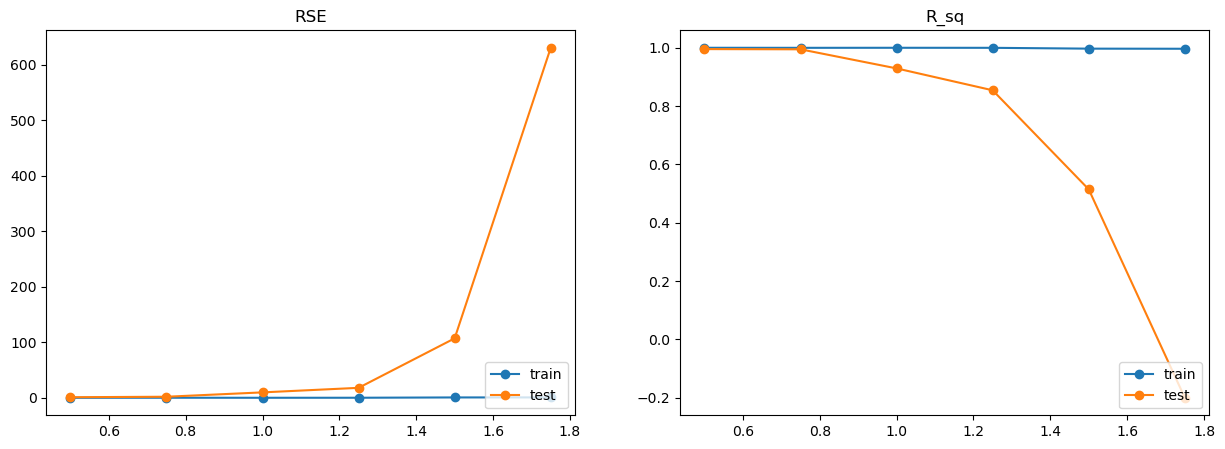

In [71]:
from modules.models import exponential1


test_ratios = np.arange(0.5, 2.0, 0.25)

res = []
for ratio in test_ratios:
    res.append(
        perform_test(
            "a0 + a1*x + a2*exp(a3*x)",
            "x",
            exponential1,
            10000,
            test_ratio=ratio
        )
    )

display("Test sample size changes")
display_stats(test_ratios, res)
print_stats(test_ratios, res)

'Data sample size changes'

C:\Users\ringa\AppData\Local\Temp\ipykernel_59388\1345222557.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


      train rse  train r_sq   test rse  test r_sq
1000   0.009615    0.996065   0.321147  -0.677307
1500   0.025880    0.993290   0.652708  -0.087767
2000   0.039310    0.995088   1.102409   0.060713
2500   0.047759    0.997124   1.389190   0.859464
3000   0.035688    0.999326   0.135012   0.998809
3500   0.085775    0.997798   3.041402   0.260730
4000   0.043030    0.999667   1.994235   0.941871
4500   0.067736    0.999505   0.346450   0.998491
5000   0.106027    0.999211   4.337232   0.724592
5500   0.109785    0.999418   3.348878   0.907154
6000   0.190150    0.998713   6.774145   0.883428
6500   0.397705    0.996041  11.467550   0.792815
7000   0.140096    0.999626   0.246680   0.999869
7500   0.091512    0.999882   1.036924   0.998092
8000   0.146822    0.999765  11.538571   0.892087
8500   0.162752    0.999778   0.256580   0.999932
9000   0.324771    0.999273   5.779622   0.967702
9500   0.364366    0.999296  23.639060   0.807077


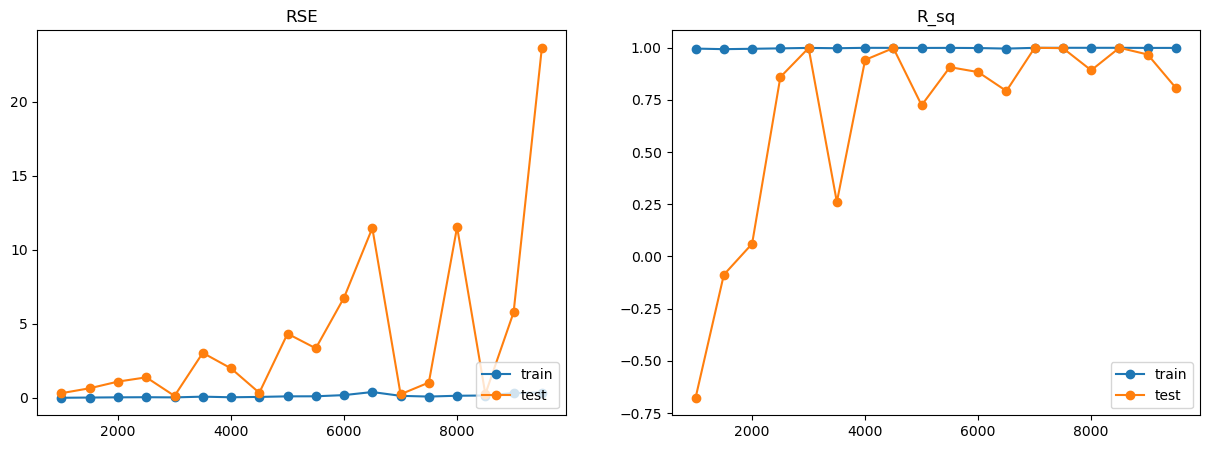

In [74]:
test_sizes = np.arange(1000, 10000, 500)

res = []
for size in test_sizes:
    res.append(
        perform_test(
            "a0 + a1*x + a2*exp(a3*x)", "x", exponential1, size
        )
    )

display("Data sample size changes")
display_stats(test_sizes, res)
print_stats(test_sizes, res)

'Test sample size changes'

C:\Users\ringa\AppData\Local\Temp\ipykernel_59388\1345222557.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


     train rse  train r_sq  test rse  test r_sq
0.5   0.024442    0.999706  0.036136   0.993864
1.0   0.018730    0.999830  0.040073   0.999357
1.5   0.016145    0.999876  0.026440   0.999690
2.0   0.007614    0.999972  0.010190   0.999949
2.5   0.026863    0.999652  0.080950   0.997114
3.0   0.015467    0.999887  0.015636   0.999894
3.5   0.020665    0.999796  0.112056   0.994607
4.0   0.022388    0.999761  0.139343   0.991407
4.5   0.034096    0.999438  0.285743   0.963452


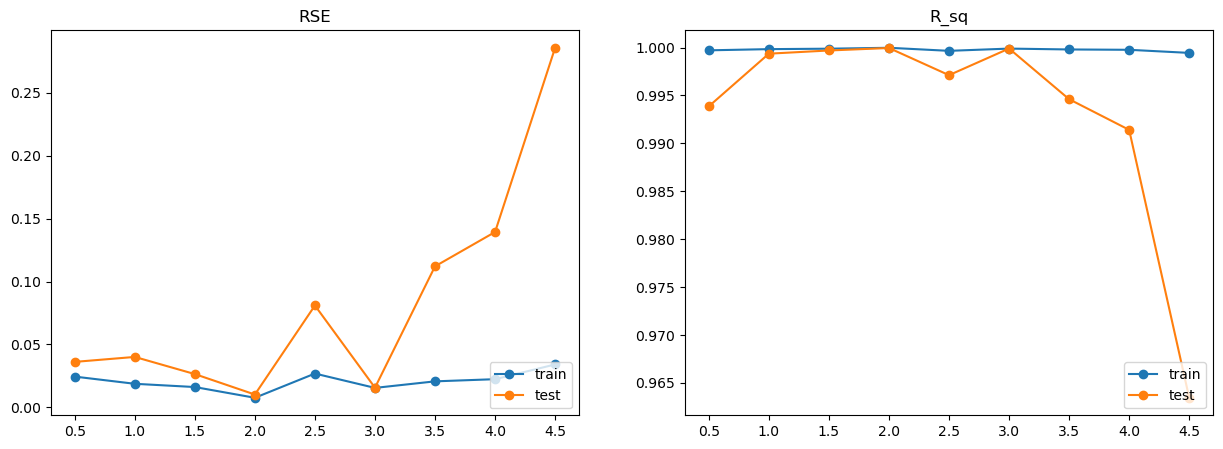

In [89]:
from modules.models import transcendental1


test_ratios = np.arange(0.5, 5.0, 0.5)

res = []
for ratio in test_ratios:
    res.append(
        perform_test(
            "a0*sin(a1*x) + a2*cos(a1*x)", "x", transcendental1, 1000, test_ratio=ratio
        )
    )

display("Test sample size changes")
display_stats(test_ratios, res)
print_stats(test_ratios, res)

'Data sample size changes'

'Function period: ~1256'

C:\Users\ringa\AppData\Local\Temp\ipykernel_59388\1345222557.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


      train rse    train r_sq  test rse      test r_sq
400         NaN           NaN       NaN            NaN
500         NaN           NaN       NaN            NaN
600         NaN           NaN       NaN            NaN
700    0.047723  9.991131e-01  0.361354       0.940969
800    0.013383  9.999286e-01  0.088954       0.996036
900    0.015607  9.998922e-01  0.026196       0.999676
1000   0.018412  9.998357e-01  0.069360       0.997643
1100   0.014275  9.999014e-01  0.024261       0.999765
1200   0.028195  9.996294e-01  0.047688       0.998967
1300   1.529989 -1.483108e+06  1.524049 -368181.350829
1400   0.019757  9.998359e-01  0.110568       0.994200
1500   0.029643  9.996281e-01  0.025827       0.999705
1600   0.012542  9.999277e-01  0.049518       0.998855
1700   0.031549  9.995351e-01  0.098741       0.995929
1800   1.471580 -2.531699e+04  1.519047   -6743.803122
1900   1.499987 -5.182846e+01  1.872925     -19.610992
2000        NaN           NaN       NaN            NaN
2100      

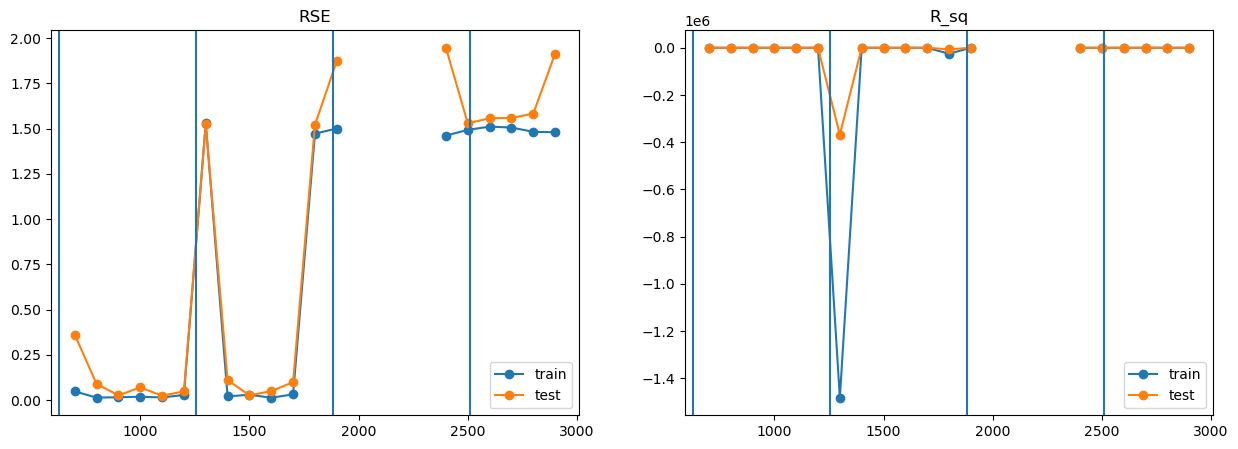

In [64]:
test_sizes = np.arange(400, 3000, 100)

res = []
for size in test_sizes:
    try:
        res.append(perform_test("a0*sin(a1*x) + a2*cos(a1*x)", "x", transcendental1, size, test_ratio=2))
    except:
        res.append(0)

display("Data sample size changes")
display("Function period: ~1256")
display_stats(test_sizes, res, period=1256)
print_stats(test_sizes, res)

'Data sample size changes'

'Function period: ~63'

C:\Users\ringa\AppData\Local\Temp\ipykernel_59388\1345222557.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


     train rse  train r_sq   test rse   test r_sq
20    2.451875    0.968479  73.911053  -29.012734
30    1.199214    0.989658   2.401206    0.982125
40    1.423387    0.985288   3.948696    0.950915
50    2.544957    0.978260   5.207447    0.935910
60    0.870883    0.997823   1.912233    0.989066
70         NaN         NaN        NaN         NaN
80    0.379842    0.999504   0.354804    0.999615
90    0.833429    0.997751   1.482581    0.992886
100   1.423687    0.991431   2.794328    0.970281
110  16.591219 -436.031978  17.660157 -123.910778
120        NaN         NaN        NaN         NaN
130        NaN         NaN        NaN         NaN
140  16.557360  -15.262455  29.016008  -11.618000
150  17.432982 -660.107776  17.333875 -163.484465
160  16.889150   -8.123677  18.315666   -9.744271
170  16.987093 -854.993394  17.698381 -232.639194
180  17.271389  -33.922585  23.668764  -15.511056
190        NaN         NaN        NaN         NaN


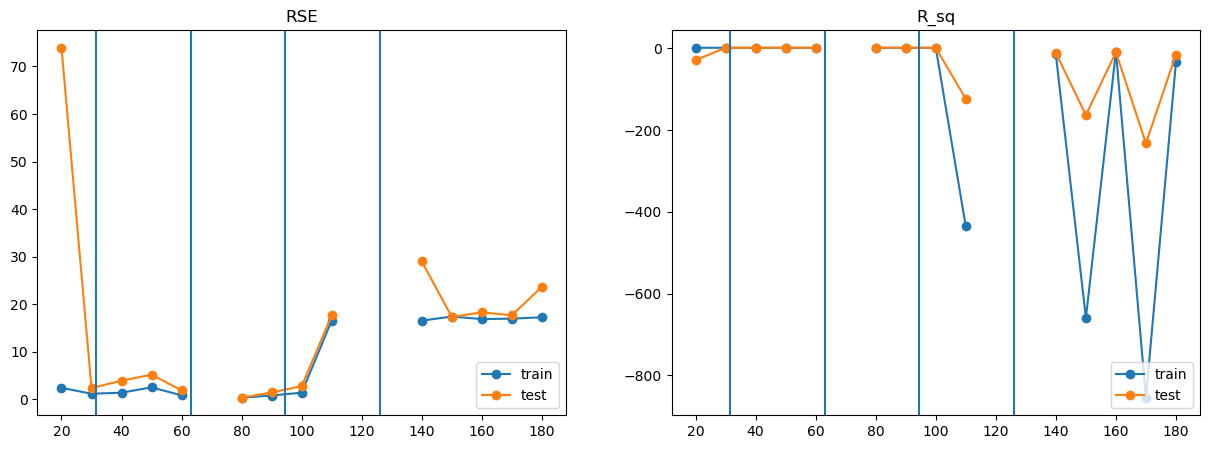

In [92]:
test_sizes = np.arange(20, 200, 10)

res = []
for size in test_sizes:
    try:
        res.append(perform_test("a0*sin(a1*x) + a2*cos(a1*x)", "x", transcendental2, size, test_ratio=2))
    except:
        res.append(0)

display("Data sample size changes")
display("Function period: ~63")
display_stats(test_sizes, res, period=63)
print_stats(test_sizes, res)

## Curvature tests

'Growth rate changes'

C:\Users\ringa\AppData\Local\Temp\ipykernel_59388\1345222557.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


      train rse  train r_sq     test rse   test r_sq
0.01  20.000270    0.986784   155.614911    0.355561
0.02   5.108220    0.999188   342.809610   -2.657448
0.03  24.341103    0.979829   502.834411   -6.233831
0.04  15.772209    0.992371   501.508855   -1.717568
0.05   8.440699    0.997682   866.006066  -20.399024
0.06  56.293580    0.904591  1145.472682  -59.633502
0.07  16.944925    0.989220  1250.174279  -48.459608
0.08  50.939171    0.881897  1404.824563  -51.218850
0.09  64.829620    0.923987   593.359323    0.785513
0.10  23.308520    0.978383  1830.769348 -132.360622
0.11  28.433247    0.973013  2018.447638 -177.953615


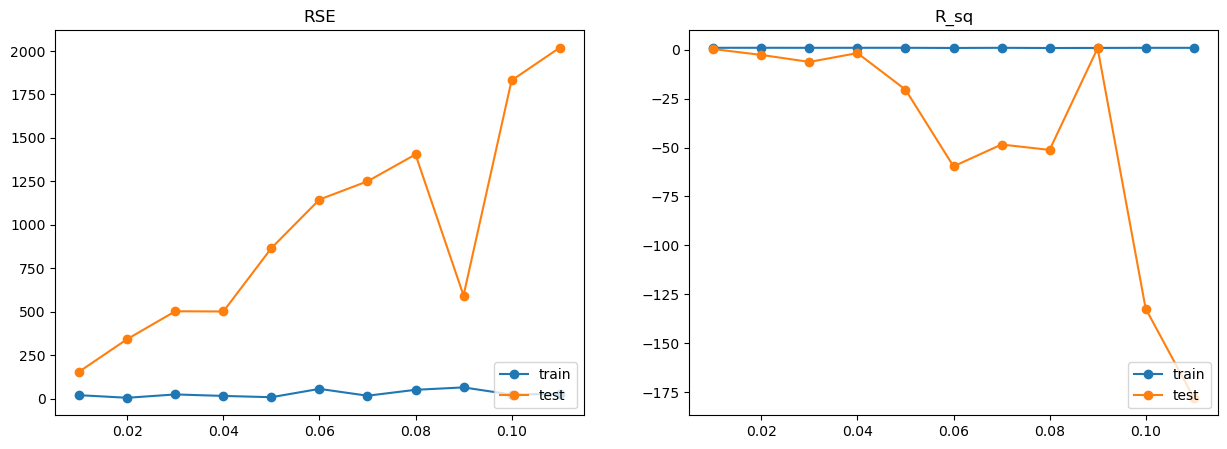

In [66]:
from modules.models import exponential2


growth_coeffs = np.arange(0.01, 0.12, 0.01)

res = []
for coeff in growth_coeffs:
    res.append(
        perform_test(
            "a0 + a1*x + a2*exp(a3*x)",
            "x",
            exponential2,
            500,
            growth_coeff=coeff
        )
    )
    

display("Growth rate changes")
display_stats(growth_coeffs, res)
print_stats(growth_coeffs, res)

C:\Users\ringa\AppData\Local\Temp\ipykernel_59388\2251970219.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


'NSE coeffs: [ 0.00108222  0.04961526 -0.02292975]'

'R_sq coeffs: [ 0.00907296 -0.08490476  0.20869765]'

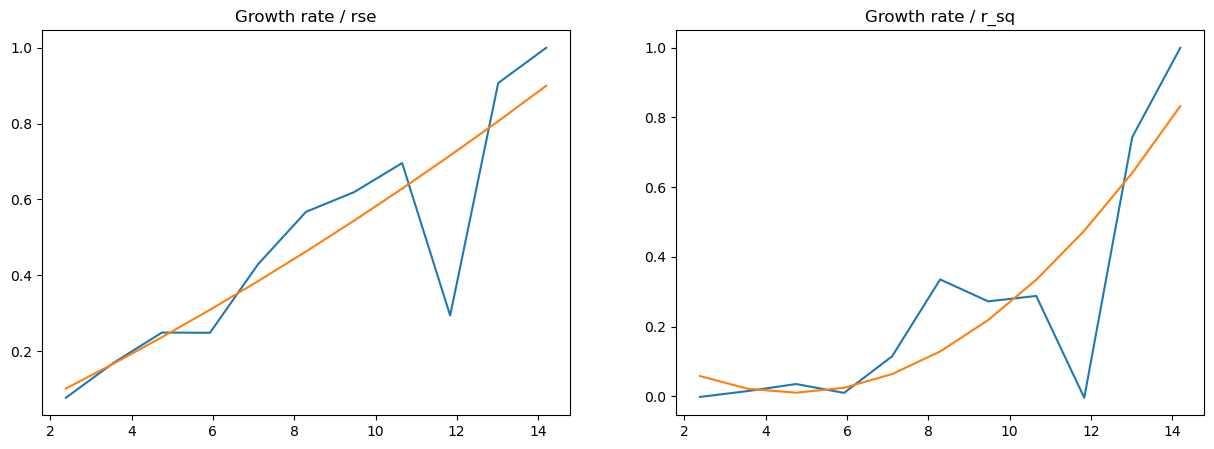

In [67]:
test_rates = []
test_stats = [[], []]
for r in res:
    test_rates.append(growth(r[2]))
    test_stats[0].append(rse(r[2], r[3]))
    test_stats[1].append(r_sq(r[2], r[3]) * (-1))

for i in range(len(test_stats[0])):
    test_stats[0][i] /= np.max(test_stats[0])
    test_stats[1][i] /= np.max(test_stats[1])

nse_coeffs = np.polyfit(test_rates, test_stats[0], 2)
r_sq_coeffs = np.polyfit(test_rates, test_stats[1], 2)
nse_poly = np.poly1d(nse_coeffs)
r_sq_poly = np.poly1d(r_sq_coeffs)
poly_stats = [[], []]
for r in test_rates:
    poly_stats[0].append(nse_poly(r))
    poly_stats[1].append(r_sq_poly(r))

fig, ax = subplots(1, 2)
fig.set_figwidth(15)
fig.set_figheight(5)
ax[0].plot(test_rates, test_stats[0])
ax[0].plot(test_rates, poly_stats[0])
ax[0].set_title("Growth rate / rse")
ax[1].plot(test_rates, test_stats[1])
ax[1].plot(test_rates, poly_stats[1])
ax[1].set_title("Growth rate / r_sq")
fig.show()

display(f"NSE coeffs: {nse_coeffs}")
display(f"R_sq coeffs: {r_sq_coeffs}")

## Complexity tests

C:\Users\ringa\AppData\Local\Temp\ipykernel_59388\1898961594.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


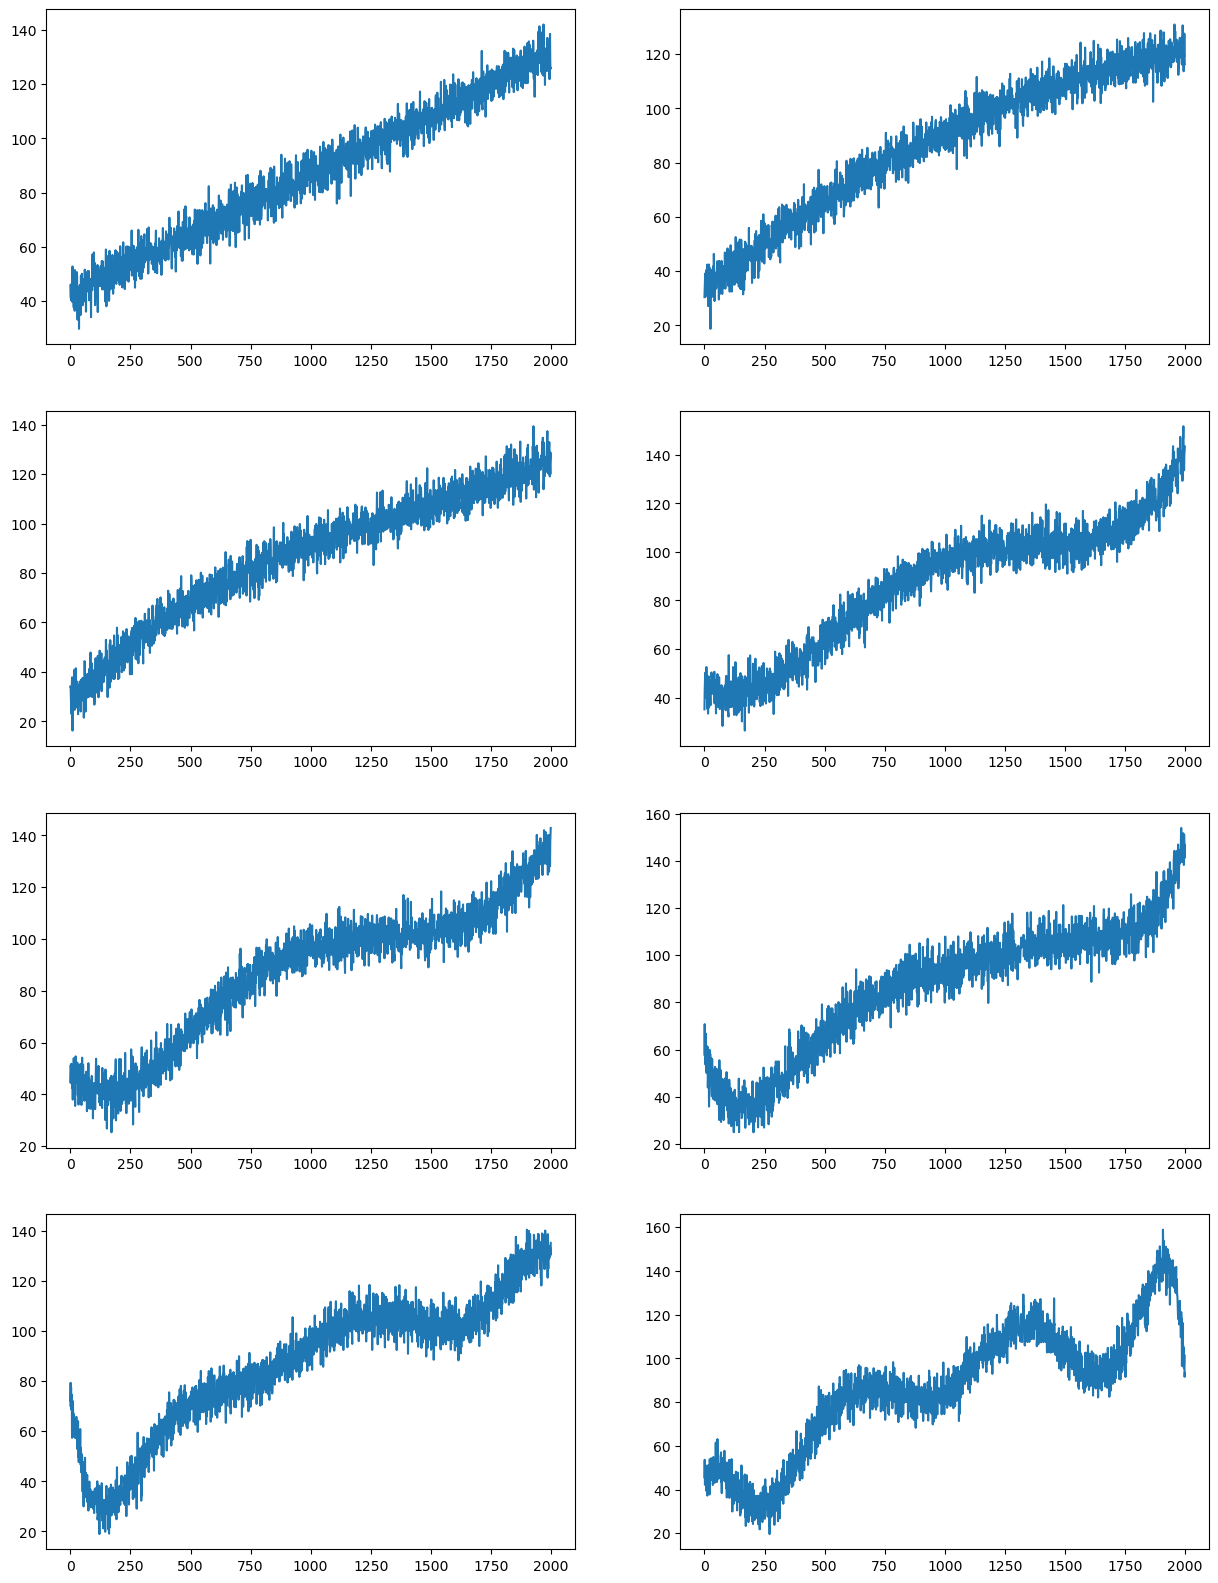

In [68]:
from modules.models import combined1

n = np.arange(2000)
combined = combined1(2000)
combined_n = apply_noise(combined, sigma=(np.max(combined) - np.min(combined)) / 5)

polys_y = []
for r in range(1, 9):
    poly = np.poly1d(np.polyfit(n, combined, r))
    buff = poly(n)
    polys_y.append(apply_noise(buff, sigma=(np.max(buff) - np.min(buff)) / 20))

fig, ax = subplots(4, 2)
fig.set_figwidth(15)
fig.set_figheight(20)

row = 0
col = 0
for pol in polys_y:
    if col == 2:
        row += 1
        col = 0
    ax[row, col].plot(n, pol)
    col += 1
fig.show()

c:\Users\ringa\OneDrive\Work\Papers\Second\pylab\modules\extra.py:178: OptimizeWarning: Covariance of the parameters could not be estimated
  coeffs_n = sc.optimize.curve_fit(


'Complexity changes'

C:\Users\ringa\AppData\Local\Temp\ipykernel_59388\1345222557.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


       train rse  train r_sq
poly2   4.465367    0.969494
poly3   4.437994    0.970308
poly4   4.895239    0.963929
poly5        NaN         NaN
poly6   7.004481    0.926143
poly7   8.076636    0.904135
poly8   8.892558    0.881418
poly9  12.145150    0.782336


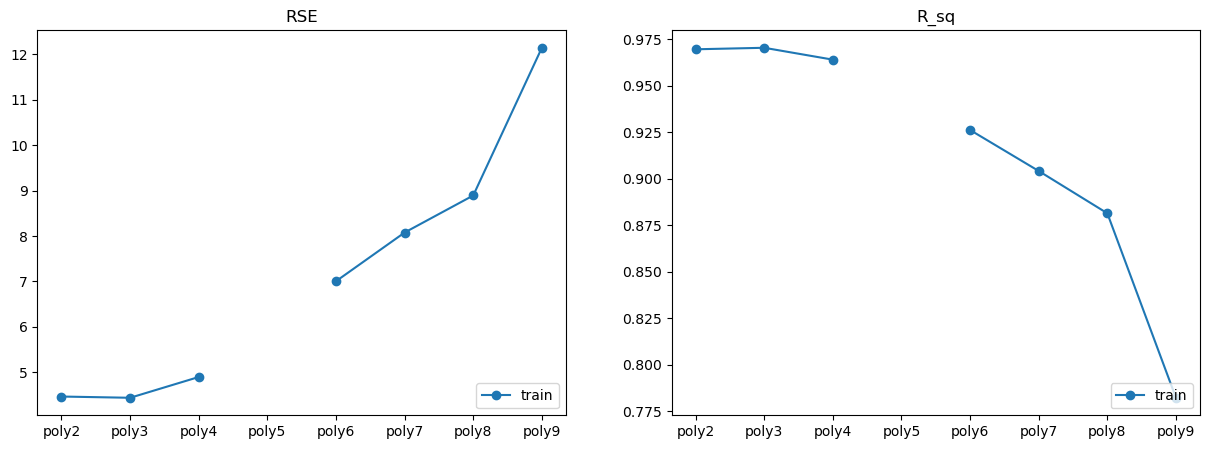

In [69]:
res = []
labels = []
p = 2
for pol in polys_y:
    labels.append(f"poly{p}")
    p += 1
    try:
        res.append(
            (pol, dsb_fit("a0 + a1*x + a2 * sin(a3 * x) + a4 * cos(a5 * x)", "x", pol))
        )
    except:
        res.append(0)


display("Complexity changes")
display_stats(labels, res, only_train=True)
print_stats(labels, res, only_train=True)